In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
from bayesinsight import BayesInsightModel, MFF

import numpyro
numpyro.set_platform("cpu")
numpyro.set_host_device_count(16)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bayesinsight.lib.transforms import saturation
import xarray as xr

In [16]:
model = BayesInsightModel.load('new_model')

In [17]:
prior = model.get_prior_predictive()

/home/mattr/Scratch/BayesInsight/bayesinsight/models/model.py:219: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior = pm.sample_prior_predictive()
Sampling: [LLT_LLT::splines_beta_mu, LLT_LLT::splines_betas, LLT_LLT::splines_betas_sd, LLT_LLT::tau, OLV Impressions_Total_Total_Total_K_, OLV Impressions_Total_Total_Total_fixed_coeff, OLV Impressions_Total_Total_Total_lag, OLV Impressions_Total_Total_Total_n_, OLV Impressions_Total_Total_Total_rand_coeff, OLV Impressions_Total_Total_Total_rand_coeff_sigma, OLV Impressions_Total_Total_Total_retention_rate_log, Price_Total_Total_Total_fixed_coeff, Price_Total_Total_Total_rand_coeff, Price_Total_Total_Total_rand_coeff_sigma, Unit Sales_Total_Total_Total_likelihood, Unit Sales_Total_Total_Total_sigma, annual_seasonality_0_fixed_coeff, annual_seasonality_0_rand_coeff, annual_seasonality_0_rand_coeff_sigma, annual_season

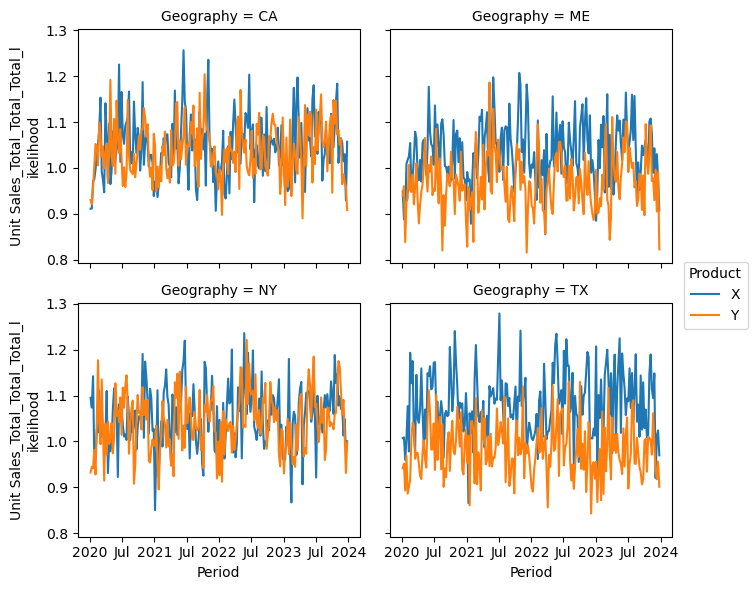

In [18]:
prior.prior_predictive['Unit Sales_Total_Total_Total_likelihood'].median(dim=['chain', 'draw']).plot.line(x="Period", col='Geography', hue='Product', col_wrap=2)  

In [135]:
df = pd.DataFrame(
  {
    "VariableName": ["Variable1", "Variable2", "Variable3", "DepVar1"],
    "Geography": ["US", "US", "US", "US"],
    "Product": ["Product1", "Product1", "Product1", "Product1"],
    "Campaign": ["Campaign1", "Campaign1", "Campaign1", "Campaign1"],
    "Outlet": ["Outlet1", "Outlet1", "Outlet1", "Outlet1"],
    "Creative": ["Creative1", "Creative1", "Creative1", "Creative1"],
    "FunctionalForm": ["S-ORIGIN", "Linear", "Log", "Linear"],
    "Lag": [1, 0, 1, 0],
    "Alpha": [.89, 0, 0, 0],
    "Beta": [1e5, 0, 0, 0],
    "Decay": [.8, 1, 1, 1],
    "MaxPer": [10, 100, 100, 100],
    "Estimate": [.3, .05, 1.2, np.NaN]
    
  }
)
VAR_STATS_COLS = list(df.columns)

df.to_csv('VariableStatistics.csv', index=False)

In [136]:
def merge_var_name(df, var_cols):
  return df[var_cols].apply(lambda x: '_'.join(["" if str(val)=='nan' else str(val) for val in x]), axis=1).values

In [137]:
merge_var_name(df, ["VariableName", "Product", "Campaign", "Outlet", "Creative"])

array(['Variable1_Product1_Campaign1_Outlet1_Creative1',
       'Variable2_Product1_Campaign1_Outlet1_Creative1',
       'Variable3_Product1_Campaign1_Outlet1_Creative1',
       'DepVar1_Product1_Campaign1_Outlet1_Creative1'], dtype=object)

In [138]:
def geometric_adstock(x: xr.DataArray|np.ndarray|pd.Series, decay, window_len=12, dim="Period", axis=-1):
  i = np.arange(window_len)
  kernel = (1-decay) ** i
  kernel = kernel / kernel.sum()
  kernel = kernel[::-1]
  kernel = xr.DataArray(kernel, dims=['conv'])
  
  if isinstance(x, np.ndarray):
    x = xr.DataArray(
      x, 
      dims=[
        dim if i==(axis if axis>0 else x.ndim-1) else f"dim_{i}" for i in range(x.ndim)
      ]
    )
  if isinstance(x, pd.Series):
    x = xr.DataArray.from_series(x)
  
  x = x.pad(**{dim: (window_len, 0)}, constant_values=0).rolling({dim: window_len}, center=False).construct(**{dim:"conv"}).dot(kernel)
  return x.isel({dim: slice(window_len, None)})
  
def lag(x: xr.DataArray|np.ndarray|pd.Series, lag: int, dim="Period", axis=-1, fill_value=None):
  
  if isinstance(x, np.ndarray):
    x = xr.DataArray(
      x, 
      dims=[
        dim if i==(axis if axis>0 else x.ndim-1) else f"dim_{i}" for i in range(x.ndim)
      ]
    )
  if isinstance(x, pd.Series):
    x = xr.DataArray.from_series(x)
    
  if fill_value is None:
    return x.shift(**{dim: lag})
  
  return x.shift(**{dim: lag}).fillna(fill_value)

In [141]:
v1 = np.random.lognormal(1, 2, 156)
v2 = np.random.normal(1, 0.3, 156)
v3 = np.exp(np.random.normal(0, 0.04, 156).cumsum())
intercept = np.ones_like(v1)
date = pd.date_range(start='2021-01-01', periods=156, freq='W-MON')
varNames = merge_var_name(df, ["VariableName", "Product", "Campaign", "Outlet", "Creative"])
data_df = pd.DataFrame(
  {key: d for key, d in zip(varNames[:-1], [v1, v2, v3])} | {'intercept': intercept, "Period": date}
).set_index('Period')
data = xr.Dataset.from_dataframe(data_df)
estimate = [.3, .05, 1.2, np.NaN]
v1_scurve = saturation(data[varNames[0]], .89, 1e5, 10, data[varNames[0]].max())
v1_adstock = geometric_adstock(v1_scurve, .8)
v1_lag = .3*lag(v1_adstock, 1, dim="Period", fill_value=0)
v2 = .05*lag(data[varNames[1]], 1, dim="Period", fill_value=0)
v3 = 1.2*np.log(data[varNames[2]])
contributions = xr.Dataset({
  varNames[0]: v1_lag,
  varNames[1]: v2,
  varNames[2]: v3,
  "intercept": 10*data["intercept"]
})

#data[varNames[3]] = np.exp(v1_lag + v2 + v3 + 10*intercept + np.random.normal(0, 0.02, 156))
#data[varNames[3]].plot()

In [142]:
contribution_mff = contributions.to_dataframe().reset_index().melt(id_vars="Period", var_name="VariableName", value_name="VarCon")
values_mff = data.to_dataframe().reset_index().melt(id_vars="Period", var_name="VariableName", value_name="VariableValue")
contribution_data = values_mff.merge(contribution_mff, on=["Period", "VariableName"])
contribution_data["VariableName"] = contribution_data.VariableName.str.split("_", expand=True)[0]
contribution_data["Geography"] = "US"
contribution_data["Product"] = "Product1"
contribution_data["Campaign"] = "Campaign1"
contribution_data["Outlet"] = "Outlet1"
contribution_data["Creative"] = "Creative1"
contribution_data.loc[contribution_data.VariableName=="intercept", ["Product", "Campaign", "Outlet", "Creative"]] = np.NaN
contribution_data.to_csv("ModelContributions.csv", index=False)

In [156]:
dep = (v1_lag + v2 + v3 + 10*intercept + np.random.normal(0, 0.05, 156))

avm = pd.DataFrame(
  data={
    "Period": date,
    "DepVar": dep,
    "DepVarMean": dep.values,
    "Model": (v1_lag + v2 + v3 + 10*intercept),
    "Residuals": dep - (v1_lag + v2 + v3 + 10*intercept)
  }
)
avm["Geography"] = "US"
avm.to_csv("ActualVsModel.csv", index=False)

<Axes: xlabel='Period'>

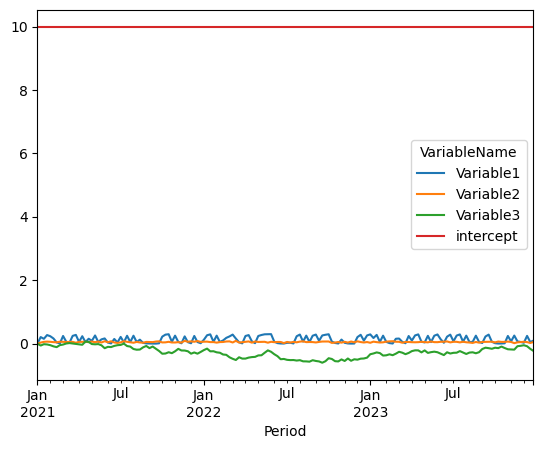

In [164]:
contribution_data.pivot(index="Period", columns="VariableName", values="VarCon").plot()

In [161]:
avm.head()

,Period,DepVar,DepVarMean,Model,Residuals,Geography
0,2021-01-04,9.951806,9.951806,9.997394,-0.045589,US
1,2021-01-11,10.258231,10.258231,10.180700,0.077532,US
2,2021-01-18,10.130928,10.130928,10.191271,-0.060343,US
3,2021-01-25,10.331249,10.331249,10.308957,0.022292,US
4,2021-02-01,10.252696,10.252696,10.244357,0.008339,US


In [328]:
from pathlib import Path
from typing import Optional, List, Dict, Union, Iterable

In [388]:
def sum_over_vars(ds: xr.Dataset):
  vars = [var for var in ds.data_vars]

  accum = ds[vars[0]].copy()
  for var in vars[1:]:
    accum += ds[var]
  return accum

class AWBModel:
  _MODEL_COLS = ["Product", "Campaign", "Outlet", "Creative"]
  _VAR_STATS_COLS = VAR_STATS_COLS
  _AVM_COLS = ["Period", "DepVar", "DepVarMean", "Model", "Residuals"]
  _CONTRIBUTION_COLS = ["Period", "VariableName", "VarCon"]
  _VALUE_COLS = ["Period", "VariableName", "VariableValue"]
  _MODEL_TRANSFORM_MAP = {
    "S-ORIGIN": saturation,
    "Linear": lambda x, **kwargs: x,
    "Log": lambda x, **kwargs: np.log(x),
  }
  
  
  def __init__(self, model_dir: Path|str, model_dims=None, is_multiplicative=False):
    if model_dims is None:
      model_dims = []
    if isinstance(model_dir, str):
      model_dir = Path(model_dir)
      
    self.model_dims = model_dims
    self.avm = self._process_avm(model_dir)
    self.contributions, self.variable_values = self._process_contributions(model_dir)
    self.model_stats = self._process_model_stats(model_dir)
    self.is_multiplicative = is_multiplicative
    
  def _process_avm(self, model_dir):
    avm = pd.read_csv(model_dir/"ActualVsModel.csv", parse_dates=["Period"])
    avm = avm[self._AVM_COLS + self.model_dims]
    return xr.Dataset.from_dataframe(avm.set_index(["Period"] + self.model_dims))
    
  def _process_contributions(self, model_dir):
    contributions = pd.read_csv(model_dir/"ModelContributions.csv", parse_dates=["Period"])
    join_cols = [col for col in self._MODEL_COLS if col not in self.model_dims]
    contributions["VariableName"] = merge_var_name(contributions, ["VariableName"] + join_cols)
    variable_values = contributions[self._VALUE_COLS + self.model_dims + join_cols]
    contributions = contributions[self._CONTRIBUTION_COLS + self.model_dims].copy()
    contributions["VariableName"] = contributions.VariableName + "_contribution"
   
    index = "Period" if len(self.model_dims)==0 else ["Period"] + self.model_dims
    variable_values = variable_values.pivot_table(index=index, columns="VariableName", values="VariableValue")
    contributions = contributions.pivot_table(index=index, columns="VariableName", values="VarCon")
    
    return (
      xr.Dataset.from_dataframe(contributions),
      xr.Dataset.from_dataframe(variable_values)
    )
  
  def _process_model_stats(self, model_dir):
    model_stats = pd.read_csv(model_dir/"VariableStatistics.csv")
    join_cols = [col for col in self._MODEL_COLS if col not in self.model_dims]
    model_stats["VariableName"] = merge_var_name(model_stats, ["VariableName"] + join_cols)
    model_dims = self.model_dims
    model_stats = model_stats.drop(columns=join_cols)
    model_stats = model_stats.set_index(["VariableName"] + model_dims)
    return xr.Dataset.from_dataframe(model_stats)
  
  def predict(self, data: Optional[xr.Dataset] = None):
    if data is None:
      return self.avm["Model"], self.contributions.copy()
    var_list = list(data.data_vars)
    unchanged_vars = [var for var in list(self.contributions.data_vars) if var not in var_list]
    base = sum_over_vars(self.contributions[unchanged_vars])
    contributions = self.contributions.copy()
    for var in var_list:
      variable_def = self.model_stats.sel(VariableName=var)
      var_con = self._apply_transform(data[var], variable_def)
      contributions = contributions.assign({f"{var}_contribution": var_con})
      base += var_con
    
    return base, contributions
  
  def _apply_transform(self, data, variable_def):
    
    transform = self._MODEL_TRANSFORM_MAP.get(variable_def.FunctionalForm.item(), lambda x, **kwargs: x)
    alpha = variable_def.Alpha.item()
    beta = variable_def.Beta.item()
    decay = variable_def.Decay.item()
    maxper = variable_def.MaxPer.item()
    transformed_data = transform(data, alpha=float(alpha), beta=float(beta), maxper=float(maxper), max=self.variable_values[data.name].max(dim="Period").values)
    adstocked_data = geometric_adstock(transformed_data, decay)
    lagged_data = lag(adstocked_data, int(variable_def.Lag), fill_value=0)
    return variable_def.Estimate * lagged_data

  

In [389]:
from scipy.optimize import minimize

In [390]:
class AWBBudgetOptimizer:
  
  def __init__(
    self, 
    model: AWBModel, 
    inital_budget: dict, 
    initial_cpm: dict, 
    variable_map: dict, 
    start_period: Union[str, pd.Timestamp],
    end_period: Union[str, pd.Timestamp],
    ):
    
    self.model = model
    self.initial_budget = inital_budget
    self.initial_cpm = initial_cpm
    self.variable_map = variable_map
    self.start_period = pd.to_datetime(start_period)
    self.end_period = pd.to_datetime(end_period)
    self.input_mask = self._make_input_mask(start_period, end_period, model.avm.Period.values)
    
  def optimize(self, budget: dict, cpm: dict, constraints: dict, total_budget_constraint: Union[float, tuple]=0):
    loss = lambda x: self._loss_function(x, budget, cpm)
    x0 = np.zeros(len(budget))
    bounds = [(constraints.get(key, (0,0))[0], constraints.get(key, (0, 0))[1]) for key in budget.keys()]
    budget_constraint = (
      {"type": "eq", "fun": lambda x: self._budget_constraint(x, budget, cpm, total_budget_constraint)}
    )
    print(loss(x0))
    print(budget_constraint["fun"](x0))
    return minimize(loss, x0, bounds=bounds, constraints=budget_constraint)
    
    
  
  def _budget_constraint(self, x, budget, cpm, total_budget_constraint):
    weights = self._weights_to_scaling_factors(x, budget, cpm)
    original_total = sum(budget.values())
    new_total = sum([self.initial_budget[key]*(1+weights[key]) for key in budget.keys()])
    if isinstance(total_budget_constraint, float|int):
      return np.maximum(0, np.abs(original_total-new_total)/original_total-total_budget_constraint)
    if isinstance(total_budget_constraint, tuple):
      return (
        np.maximum(0, (original_total - new_total)/original_total-total_budget_constraint[0])
        + np.maximum(0, (new_total - original_total)/original_total-total_budget_constraint[1])
      )
  
  def _get_scaling_factor(
        self,
        original_spend: float, 
        new_spend: float, 
        original_cpm: float, 
        new_cpm: float) -> float:
    """Scale for impressions"""
    original_imps = original_spend/original_cpm * 1000
    new_imps = new_spend/new_cpm * 1000
    return new_imps/original_imps
  
  def _weights_to_scaling_factors(
        self,
        x: List[float], 
        new_budgets: Dict[str, float], 
        new_cpms: Dict[str, float]
        ) -> Dict[str, float]:
    """Scale impressions during the start and end period by 
    the fraction more or less impressions the new budget would imply based on 
    the old budget and cpms.
    This allows the solver to look through percentage increase/decrease bounds instead of actuall $ amounts.
    """
    scaling_factor = {
        key: self._get_scaling_factor(
            self.initial_budget[key],
            new_budgets[key]*(1+x[i]),
            self.initial_cpm[key],
            new_cpms[key])-1
            for i, key in enumerate(self.initial_budget.keys()) 
    }
    
    return scaling_factor
  
  def _make_input_mask(
        self,
        start_period: Union[str, pd.Timestamp], 
        end_period: Union[str, pd.Timestamp], 
        model_dates: Iterable[pd.Timestamp]
        ) -> xr.DataArray:
    """Treat periods outside the masked period as if they didn't change"""

    if isinstance(start_period, str):
        start_period = pd.to_datetime(start_period)
    
    if isinstance(end_period, str):
        end_period = pd.to_datetime(end_period)

    input_mask = xr.DataArray(
        np.ones_like(model_dates, dtype=float),
        dims=("Period",),
        coords={"Period": model_dates}
    ).where(
        lambda x: (x.Period > start_period) & (x.Period < end_period), 
        0
    )
    return input_mask
  
  def weights_to_results(
    self,
    x,
    new_budget,
    new_cpm,
    ):
    
    updated_weights = self._weights_to_scaling_factors(x, new_budget, new_cpm)
    updated_data = xr.Dataset({
        media_var: (
            (updated_weights[self.variable_map[media_var]]*self.input_mask + 1)
            *model.variable_values[media_var]
        ).transpose(*model.variable_values[media_var].dims)
        for media_var in self.variable_map.keys()}
      )
        
    return self.model.predict(updated_data)
  
  def _loss_function(
        self,
        x, 
        new_budget, 
        new_cpm, 
        ):
    
    det, _ = self.weights_to_results(x, new_budget, new_cpm)
    if self.model.is_multiplicative:
      return -np.exp(det).sel(Period=slice(self.start_period, self.end_period)).sum().values
    return -det.sel(Period=slice(self.start_period, self.end_period)).sum().values
  
  
  

In [391]:
model = AWBModel(model_dir=".")
optimizer = AWBBudgetOptimizer(
  model,
  inital_budget={"Var1": 1000, "Var2": 2000},
  initial_cpm={"Var1": 10, "Var2": 20},
  variable_map={"Variable1_Product1_Campaign1_Outlet1_Creative1": "Var1", 
                "Variable2_Product1_Campaign1_Outlet1_Creative1": "Var2"},
  start_period="2021-01-01",
  end_period="2021-06-01")

In [392]:
sol = optimizer.optimize(
  budget={"Var1": 1000, "Var2": 3000},
  cpm={"Var1": 10, "Var2": 20},
  constraints={"Var1": (-.5, 0.5), "Var2": (-0.5, 0.5)},
  total_budget_constraint=0.0
)

-228.49272761608745
0.0


In [386]:
1000*1.5 + 3000*(1-.1667)

3999.9

In [321]:
model.model_stats.FunctionalForm.sel(VariableName="Variable1_Product1_Campaign1_Outlet1_Creative1").item()

'S-ORIGIN'

In [322]:
model.avm.DepVar.name

'DepVar'

In [323]:
model = AWBModel(".")

In [324]:
list(model.variable_values.data_vars)

['Variable1_Product1_Campaign1_Outlet1_Creative1',
 'Variable2_Product1_Campaign1_Outlet1_Creative1',
 'Variable3_Product1_Campaign1_Outlet1_Creative1',
 'intercept____']

In [326]:
prediction, contributions = model.predict(
  xr.Dataset(
    {'Variable1_Product1_Campaign1_Outlet1_Creative1': 
      model.variable_values.Variable1_Product1_Campaign1_Outlet1_Creative1
      }))

In [289]:
model.avm.DepVar

<xarray.DataArray 'DepVar' (Period: 156)> Size: 1kB
array([ 9.9518056 , 10.25823148, 10.13092761, 10.3312494 , 10.25269643,
       10.07975947, 10.02000817, 10.09474218, 10.13872202, 10.14946845,
       10.04721558, 10.31029799, 10.28514476, 10.09216191, 10.11061104,
       10.19639746, 10.29015487, 10.17245329, 10.26890215, 10.08008974,
       10.18702213, 10.05464822,  9.96169722,  9.94043758, 10.17914593,
        9.9933742 , 10.14690633, 10.1131169 , 10.25223705, 10.04051931,
       10.09824292,  9.87833707, 10.0061534 ,  9.96366505, 10.03095192,
        9.92368358,  9.99596751,  9.93067171,  9.83573096,  9.94169548,
       10.03432075, 10.13372651,  9.80195336, 10.05398522,  9.8963531 ,
        9.88503768, 10.15777177,  9.91892785,  9.7169077 , 10.00832869,
        9.84288584,  9.95299763,  9.95363528, 10.12695476, 10.12080572,
        9.98389505, 10.00081406,  9.80381165,  9.75581141,  9.78899619,
        9.86207011,  9.82378903,  9.72858376,  9.65465445,  9.58388744,
        9.88991548,  9.82215714,  9.6367021 ,  9.65946525,  9.97171128,
        9.97855291,  9.9951634 , 10.22520709, 10.16408092,  9.75152773,
        9.68390213,  9.61167126,  9.56232922,  9.49123245,  9.63370672,
        9.56808094,  9.78474595,  9.82962329,  9.56221766,  9.731189  ,
        9.61140024,  9.75299533,  9.82781443,  9.55870896,  9.67854613,
        9.84373805,  9.97132572,  9.65963727,  9.56038178,  9.55269179,
        9.67555091,  9.46262767,  9.53146057,  9.45475547,  9.58565589,
        9.79619686,  9.89069655,  9.61209777,  9.89009762,  9.97209595,
        9.97839983, 10.1348837 ,  9.78355416,  9.914329  ,  9.7269795 ,
        9.75185016,  9.75310539,  9.91321574,  9.87474511,  9.79166087,
        9.66337748, 10.03711154,  9.94306   , 10.11113156, 10.05282105,
        9.81617002,  9.90245657,  9.99414804,  9.84079544, 10.02736943,
       10.0824609 , 10.00414719,  9.78397355, 10.05013662, 10.02904876,
        9.92752768, 10.057525  , 10.07340068,  9.92278501,  9.9692677 ,
        9.80050727,  9.84674655, 10.11055348,  9.84250371,  9.93550899,
       10.25223311, 10.16342426,  9.92630864,  9.95114653,  9.89168032,
        9.95339171,  9.95346619, 10.16817301,  9.93255564, 10.0933027 ,
       10.03805426, 10.06857387,  9.98962386, 10.26763103,  9.91090098,
        9.95959149])
Coordinates:
  * Period   (Period) datetime64[ns] 1kB 2021-01-04 2021-01-11 ... 2023-12-25

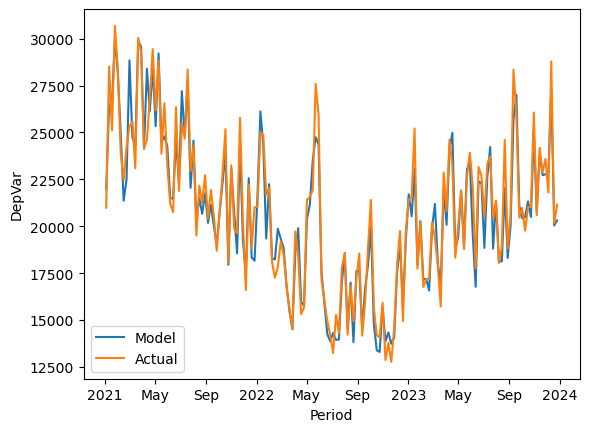

In [225]:
np.exp(sum_over_vars(model.contributions)).plot(ax= plt.gca(), label="Model")
np.exp(model.avm.DepVar).plot(ax=plt.gca(), label="Actual")
plt.legend()